In [1]:
from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease               
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease             
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, LayerNormalization, Input, Activation, Lambda, Bidirectional, Add, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D, \
    GlobalMaxPooling1D, Concatenate, ThresholdedReLU, Average
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import json
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
import os
import joblib
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.metrics import AUC
from scipy import stats

folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")

random_state_value = None

2024-11-26 05:41:43.497052: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 05:41:43.497104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 05:41:43.497156: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 05:41:43.506575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow

In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    """
    Add time-based features to the DataFrame.
    Works with both 'datetime' as column or index.
    """
    # Se datetime è l'indice, lo usiamo direttamente
    if isinstance(df.index, pd.DatetimeIndex):
        datetime_col = df.index
    else:
        # Se datetime è una colonna, la convertiamo
        if 'datetime' in df.columns:
            datetime_col = pd.to_datetime(df['datetime'])
        else:
            raise ValueError("No datetime column or index found in DataFrame")

    # Creazione delle feature temporali
    df['timestamp'] = datetime_col.astype(np.int64) // 10 ** 9
    df['year'] = datetime_col.year
    df['month'] = datetime_col.month
    df['day'] = datetime_col.day
    df['hour'] = datetime_col.hour
    df['minute'] = datetime_col.minute
    df['hour_sin'] = np.sin(datetime_col.hour * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(datetime_col.hour * (2 * np.pi / 24))
    df['day_of_week'] = datetime_col.dayofweek
    df['day_of_year'] = datetime_col.dayofyear
    df['week_of_year'] = datetime_col.isocalendar().week.astype(int)
    df['quarter'] = datetime_col.quarter
    df['is_month_end'] = datetime_col.is_month_end.astype(int)
    df['is_quarter_end'] = datetime_col.is_quarter_end.astype(int)
    df['is_year_end'] = datetime_col.is_year_end.astype(int)
    df['month_sin'] = np.sin(datetime_col.month * (2 * np.pi / 12))
    df['month_cos'] = np.cos(datetime_col.month * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(datetime_col.dayofyear * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(datetime_col.dayofyear * (2 * np.pi / 365.25))
    df['season'] = datetime_col.map(get_season)
    df['time_period'] = datetime_col.hour.map(get_time_period)

    return df


def add_solar_features(df):
    # Solar angle calculation
    df['solar_angle'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Interactions between relevant features
    df['cloud_temp_interaction'] = df['cloudcover'] * df['temp']
    df['visibility_cloud_interaction'] = df['visibility'] * (100 - df['cloudcover'])

    # Derived features
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_gradient'] = df['temp'] - df['tempmin']

    return df


def add_solar_specific_features(df):
    """
    Aggiunge feature specifiche per la predizione della radiazione solare
    combinando caratteristiche astronomiche e meteorologiche
    """
    # Caratteristiche astronomiche
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = 12 - df['hour']
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Angolo solare teorico
    df['solar_angle'] = np.sin(df['hour_sin']) * np.sin(df['day_of_year_sin'])

    # Interazioni con condizioni atmosferiche
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100

    # Indici di chiarezza e trasmissione
    df['clearness_index'] = (100 - df['cloudcover']) * df['visibility'] / 10000
    df['atmospheric_attenuation'] = (df['pressure'] / 1013.25) * (1 - (df['humidity'] / 100) * 0.6)

    # Radiazione teorica e attenuazione
    df['theoretical_radiation'] = df['solar_angle'].clip(0, 1) * 1000
    df['expected_radiation'] = df['theoretical_radiation'] * df['clearness_index']

    # Rolling features
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()
    df['uv_rolling_12h'] = df['uvindex'].rolling(window=12).mean()

    # Interazioni temperatura-radiazione
    df['temp_radiation_potential'] = df['temp'] * df['solar_elevation']

    return df


def add_radiation_energy_features(df):
    """Adds specific features based on solarenergy and uvindex"""

    # Assicuriamoci che l'indice sia di tipo datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df['datetime'])

    # Solar energy to UV ratio (independent from solarradiation)
    df['energy_uv_ratio'] = df['solarenergy'] / (df['uvindex'] + 1e-6)

    # Time aggregations
    # Moving averages
    windows = [3, 6, 12, 24]  # hours
    for w in windows:
        df[f'energy_rolling_mean_{w}h'] = df['solarenergy'].rolling(window=w).mean()
        df[f'uv_rolling_mean_{w}h'] = df['uvindex'].rolling(window=w).mean()

    # Daily aggregations utilizzando datetime
    df['energy_daily_sum'] = df.groupby(df.index.date)['solarenergy'].transform('sum')
    df['uv_daily_max'] = df.groupby(df.index.date)['uvindex'].transform('max')

    # Changes
    df['energy_change'] = df['solarenergy'].diff()
    df['uv_change'] = df['uvindex'].diff()

    # Lag features
    lags = [1, 2, 3, 6, 12, 24]  # hours
    for lag in lags:
        df[f'energy_lag_{lag}h'] = df['solarenergy'].shift(lag)
        df[f'uv_lag_{lag}h'] = df['uvindex'].shift(lag)

    # Peak indicators
    df['is_energy_peak'] = (df['solarenergy'] > df['energy_rolling_mean_6h'] * 1.2).astype(int)
    df['is_uv_peak'] = (df['uvindex'] > df['uv_rolling_mean_6h'] * 1.2).astype(int)

    # Aggiungiamo alcune metriche di volatilità
    df['energy_volatility'] = df['energy_change'].rolling(window=24).std()
    df['uv_volatility'] = df['uv_change'].rolling(window=24).std()

    # Indice di intensità solare composito
    df['solar_intensity_index'] = (df['solarenergy'] * df['uvindex']) / (df['cloudcover'] + 1e-6)

    # Interazioni
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100
    df['energy_temp_interaction'] = df['solarenergy'] * df['temp']

    return df


def add_advanced_features(df):
    """
    Add all advanced features to the DataFrame
    Assumes df has a DatetimeIndex
    """
    # Verifichiamo che abbiamo un DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")

    # Existing features
    df = add_time_features(df)
    df = add_solar_features(df)
    df = add_solar_specific_features(df)
    df = add_radiation_energy_features(df)

    # Weather variable interactions
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']

    # Derived features
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    # Rolling means
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()

    # Lag features
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    # Extreme conditions indicator
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) &
                                (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=['season', 'time_period'])

    return df


def prepare_advanced_data(df):
    """
    Prepare data for advanced modeling with proper datetime handling
    """
    # Assicuriamoci che abbiamo una copia del DataFrame
    df = df.copy()

    # Verifichiamo se datetime è già l'indice
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError("No datetime column or index found in DataFrame")

    # Ordiniamo il DataFrame per datetime
    df = df.sort_index()

    # Apply feature engineering functions
    df = add_advanced_features(df)

    #all_columns = list(df.columns)
    #print(all_columns)

    features = {
        # Primary Features (strong direct correlation)
        'primary_features': [
            'uvindex',  # Direct radiation indicator
            'cloudcover',  # Cloud coverage
            'visibility',  # Atmospheric transparency
            'temp',  # Temperature
            'pressure',  # Atmospheric pressure
            'humidity',  # Humidity
        ],

        # Astronomical and Temporal Features
        'astronomical_features': [
            'solar_elevation',  # Solar elevation
            'solar_angle',  # Solar angle
            'day_length',  # Day length
            'hour_sin',  # Daily cycle
            'hour_cos',
            'day_of_year_sin',  # Annual cycle
            'day_of_year_cos',
            'month_sin',  # Monthly cycle
            'month_cos',
        ],

        # Key Indices and Interactions
        'key_interactions': [
            'clear_sky_index',  # Clear sky index
            'atmospheric_attenuation',  # Atmospheric attenuation
            'theoretical_radiation',  # Theoretical radiation
            'expected_radiation',  # Expected radiation
            'cloud_elevation',  # Cloud-elevation interaction
            'visibility_elevation',  # Visibility-elevation interaction
            'uv_cloud_interaction',  # UV-cloud interaction
            'temp_radiation_potential',  # Temperature-radiation potential
        ],

        # Rolling Features (temporal trends)
        'rolling_features': [
            'cloud_rolling_12h',  # Cloud coverage moving average
            'temp_rolling_12h',  # Temperature moving average
            'uv_rolling_12h',  # UV moving average
            'cloudcover_rolling_mean_6h',
            'temp_rolling_mean_6h',
        ],

        # Lag Features (most recent)
        'lag_features': [
            'temp_1h_lag',  # 1-hour temperature lag
            'cloudcover_1h_lag',  # 1-hour cloud coverage lag
            'humidity_1h_lag',  # 1-hour humidity lag
            'uv_lag_1h',  # 1-hour UV lag
        ],

        # Categorical Features
        'categorical_features': [
            'season_Spring',  # Seasons
            'season_Summer',
            'season_Autumn',
            'season_Winter',
            'time_period_Morning',  # Time periods
            'time_period_Afternoon',
            'time_period_Evening',
            'time_period_Night',
        ]
    }

    final_features = [feature for group in features.values() for feature in group]

    # Handle missing values
    target_variables = ['solarradiation', 'solarenergy', 'uvindex']
    for column in final_features + target_variables:
        if column in df.columns:
            df[column] = df[column].interpolate(method='time')

    df.fillna(0, inplace=True)

    # Temporal split
    data_after_2010 = df[df['year'] >= 2010].copy()
    data_before_2010 = df[df['year'] < 2010].copy()

    X = data_after_2010[final_features]
    y = data_after_2010['solarradiation']
    X_to_predict = data_before_2010[final_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state_value, shuffle=False
    )

    # Scaling
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    X_to_predict_scaled = scaler_X.transform(X_to_predict)

    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Print info about selected features
    print("\nSelected features:")
    print(f"Number of features: {len(final_features)}")
    print("Features list:", final_features)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, final_features, X_to_predict_scaled


def create_sequence_data(X, sequence_length=24):
    """
    Converts data into sequences for LSTM input
    sequence_length represents how many previous hours to consider
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convert data into sequences
    sequence_length = 24  # 24 hours of historical data

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adjust y by removing the first (sequence_length-1) elements
    y_train = y_train_scaled[sequence_length - 1:]
    y_test = y_test_scaled[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, scaler_X, scaler_y, features, X_to_predict_seq

In [4]:
def create_residual_lstm_layer(x, units, dropout_rate, l2_reg=0.01, return_sequences=True, survival_probability=0.8):
    """
    Creates a bidirectional LSTM layer with residual connections and regularization.

    Parameters:
        x: Input tensor
        units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
        l2_reg: L2 regularization factor
        return_sequences: Whether to return sequences or just the last output
        survival_probability: Probability of layer survival for stochastic depth
    """
    residual = x
    x = Bidirectional(LSTM(units, return_sequences=return_sequences, kernel_regularizer=regularizers.l2(l2_reg)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)

    if return_sequences:
        if int(residual.shape[-1]) != 2 * units:
            residual = Dense(2 * units, activation='linear')(residual)
        x = tfa.layers.StochasticDepth(survival_probability)([x, residual])
    return x


def attention_block(x, units, num_heads=8, survival_probability=0.8):
    """
    Creates a multi-head attention block with residual connections.

    Parameters:
        x: Input tensor
        units: Dimension of the key space
        num_heads: Number of attention heads
        survival_probability: Probability of layer survival for stochastic depth
    """
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=units)(x, x)
    x = tfa.layers.StochasticDepth(survival_probability)([x, attention])
    x = LayerNormalization()(x)
    return x


def asymmetric_loss(y_true, y_pred):
    """
    Loss function che penalizza maggiormente la sottostima dei valori alti
    """
    diff = y_true - y_pred
    abs_diff = tf.abs(diff)

    # Calcola il peso basato sul valore reale
    value_weight = tf.exp(y_true / tf.reduce_max(y_true)) - 1

    # Penalizza maggiormente la sottostima (quando y_pred < y_true)
    underestimation_penalty = tf.where(diff > 0, 2.0, 1.0)

    # Combina i pesi
    total_weight = value_weight * underestimation_penalty

    # Calcola la loss pesata
    weighted_loss = total_weight * abs_diff

    return tf.reduce_mean(weighted_loss)

def add_peak_features(x):
    """
    Aggiunge feature specifiche per identificare potenziali picchi
    """
    # Moving average delle ultime n osservazioni
    ma = tf.keras.layers.Conv1D(1, kernel_size=5, padding='same')(x)

    # Differenza dal moving average (identifica anomalie)
    diff_ma = Lambda(lambda x: x[0] - x[1])([x, ma])

    # Rate of change
    roc = Lambda(lambda x: x[:, 1:] - x[:, :-1])(x)
    roc = tf.pad(roc, [[0, 0], [1, 0], [0, 0]])

    # Concatena tutte le feature
    enhanced_x = Concatenate()([x, diff_ma, roc])

    return enhanced_x

def create_regression_branch(shared_features, l2_lambda=0.005, name_suffix=''):
    """
    Branch di regressione migliorato per valori alti
    """
    # Branch principale
    main_branch = shared_features
    dense_units = [512, 256, 128, 64]  # Unità aumentate

    for units in dense_units:
        main_branch = Dense(
            units,
            kernel_regularizer=regularizers.l2(l2_lambda)
        )(main_branch)
        main_branch = BatchNormalization()(main_branch)
        main_branch = Activation('swish')(main_branch)

    # Branch specializzato per valori alti
    high_values_branch = shared_features
    for units in [256, 128, 64]:
        high_values_branch = Dense(
            units,
            kernel_regularizer=regularizers.l2(l2_lambda),
            activation='relu'  # Usa ReLU per preservare valori alti
        )(high_values_branch)

    # Gate per decidere quanto pesare il branch dei valori alti
    gate = Dense(1, activation='sigmoid')(shared_features)

    # Combina i branch
    main_output = Dense(1)(main_branch)
    high_values_output = Dense(1)(high_values_branch)

    # Output finale pesato
    final_output = Lambda(lambda x: x[0] * (1 - x[2]) + x[1] * x[2])(
        [main_output, high_values_output, gate]
    )

    return final_output

def create_peak_specialized_ensemble(shared_features, l2_lambda=0.005):
    """
    Ensemble di modelli specializzati per diverse fasce di valori
    """
    # Modello generale
    general_model = create_regression_branch(shared_features, name_suffix='general')

    # Modello specializzato per valori alti
    high_values_features = Dense(256, activation='relu')(shared_features)
    high_values_model = create_regression_branch(high_values_features, name_suffix='high')

    # Modello specializzato per picchi estremi
    peak_features = Dense(512, activation='relu')(shared_features)
    peak_model = create_regression_branch(peak_features, name_suffix='peak')

    # Gate network per pesare i modelli
    gate_features = Concatenate()([shared_features,
                                   Dense(32)(shared_features),
                                   Dense(32)(high_values_features),
                                   Dense(32)(peak_features)])

    gates = Dense(3, activation='softmax')(gate_features)

    # Combina le predizioni
    final_output = Lambda(lambda x: (x[0] * x[3][:, 0:1] +
                                     x[1] * x[3][:, 1:2] +
                                     x[2] * x[3][:, 2:3]))([general_model,
                                                            high_values_model,
                                                            peak_model,
                                                            gates])

    return final_output

def create_solarradiation_model(input_shape, folder_name, l2_lambda=0.005, min_output=0, max_output=1):
    """
    Creates a hybrid model with enhanced peak prediction capabilities
    """
    inputs = Input(shape=input_shape)

    # Backbone comune
    survival_probs = [0.9, 0.8, 0.7, 0.6]
    attention_survival_probs = [0.85, 0.75, 0.65, 0.55]
    lstm_units = [256, 128, 64, 32]
    dropout_rates = [0.4, 0.3, 0.2, 0.2]
    attention_heads = [32, 24, 16, 8]

    x = inputs
    lstm_blocks = 4
    for i in range(lstm_blocks):
        x = create_residual_lstm_layer(
            x,
            units=lstm_units[i],
            dropout_rate=dropout_rates[i],
            l2_reg=l2_lambda,
            return_sequences=True,
            survival_probability=survival_probs[i]
        )
        x = attention_block(
            x,
            units=lstm_units[i],
            num_heads=attention_heads[i],
            survival_probability=attention_survival_probs[i]
        )
        if i < lstm_blocks - 1:
            x = MaxPooling1D()(x)

    # Final shared LSTM layer
    shared_features = create_residual_lstm_layer(
        x,
        units=32,
        dropout_rate=0.1,
        l2_reg=l2_lambda,
        return_sequences=False,
        survival_probability=0.6
    )

    # Enhance features for peak detection
    enhanced_features = add_peak_features(x)
    enhanced_shared_features = create_residual_lstm_layer(
        enhanced_features,
        units=64,  # Increased units for enhanced features
        dropout_rate=0.1,
        l2_reg=l2_lambda,
        return_sequences=False,
        survival_probability=0.6
    )

    # Classification branch
    classification_x = Dense(64, kernel_regularizer=regularizers.l2(l2_lambda))(shared_features)
    classification_x = BatchNormalization()(classification_x)
    classification_x = Activation('swish')(classification_x)
    classification_x = Dropout(0.2)(classification_x)
    classification_x = Dense(32, kernel_regularizer=regularizers.l2(l2_lambda))(classification_x)
    classification_x = BatchNormalization()(classification_x)
    classification_x = Activation('swish')(classification_x)
    classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_x)

    # Combined features for regression
    regression_features = Concatenate()([shared_features, enhanced_shared_features])

    # Create specialized ensemble for regression
    regression_output = create_peak_specialized_ensemble(regression_features, l2_lambda)

    # Clip regression values
    regression_output = Lambda(
        lambda x: tf.clip_by_value(x, min_output, max_output),
        name='regression_output'
    )(regression_output)

    # Combine outputs using threshold activation
    thresholded_classification = ThresholdedReLU(theta=0.5)(classification_output)
    normalized_classification = Lambda(lambda x: tf.cast(x > 0, tf.float32))(thresholded_classification)
    final_output = Lambda(
        lambda inputs: inputs[0] * inputs[1],
        name='final_output'
    )([regression_output, normalized_classification])

    # Create model
    model = Model(
        inputs=inputs,
        outputs=[
            classification_output,
            regression_output,
            final_output
        ],
        name="SolarRadiationModel"
    )

    # Custom loss functions
    def hybrid_focal_loss(y_true, y_pred):
        mse = tf.square(y_true - y_pred)
        error_ratio = tf.abs(y_true - y_pred) / (tf.abs(y_true) + 1.0)
        focal_weight = tf.pow(error_ratio, 2)
        weighted_mse = focal_weight * mse
        mae = tf.abs(y_true - y_pred)
        return tf.reduce_mean(0.7 * weighted_mse + 0.3 * mae)

    def masked_regression_loss(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
        return asymmetric_loss(y_true * mask, y_pred * mask)

    # Metrics
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    def custom_mape(y_true, y_pred):
        epsilon = 1e-7
        diff = tf.abs((y_true - y_pred) / (y_true + epsilon))
        diff = tf.clip_by_value(diff, 0, 1)
        return tf.reduce_mean(diff) * 100

    # Optimizer with reduced initial learning rate
    optimizer = AdamW(
        learning_rate=0.0002,  # Reduced from 0.0003
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        weight_decay=0.001,
        amsgrad=True
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss={
            'classification_output': 'binary_crossentropy',
            'regression_output': masked_regression_loss,
            'final_output': hybrid_focal_loss
        },
        loss_weights={
            'classification_output': 0.2,
            'regression_output': 0.5,
            'final_output': 0.3
        },
        metrics={
            'classification_output': ['accuracy', AUC()],
            'regression_output': ['mse', 'mae', rmse, custom_mape],
            'final_output': ['mse', 'mae', rmse, custom_mape]
        }
    )

    model.summary()

    # Save model architecture visualization
    plot_model(
        model,
        to_file=f'{folder_name}_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        dpi=150,
        show_layer_activations=True
    )

    return model


def evaluate_solarradiation_predictions(y_true, y_pred, hour=None, folder_name=None):
    """
    Comprehensive evaluation of solar radiation predictions with detailed analysis and visualizations.

    Parameters:
    -----------
    y_true : array-like
        Actual solar radiation values (W/m²)
    y_pred : array-like
        Predicted solar radiation values (W/m²)
    hour : array-like, optional
        Array of hours corresponding to predictions, for temporal analysis
    folder_name : str, optional
        Directory to save analysis plots

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """

    # Data preparation
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    errors = y_pred - y_true

    # Basic metrics calculation
    mae_raw = mean_absolute_error(y_true, y_pred)
    rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_raw = r2_score(y_true, y_pred)

    # Corrected MAPE calculation
    mask = y_true > 10  # Consider only values above 10 W/m²
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    # Corrected error margin accuracy
    within_5_percent = np.mean(np.abs(errors) <= 5) * 100  # Within 5 W/m²
    within_10_percent = np.mean(np.abs(errors) <= 10) * 100  # Within 10 W/m²
    within_20_percent = np.mean(np.abs(errors) <= 20) * 100  # Within 20 W/m²

    # Radiation level classification
    def get_radiation_level(value):
        if value <= 200:
            return 'Very Low'
        elif value <= 400:
            return 'Low'
        elif value <= 600:
            return 'Moderate'
        elif value <= 800:
            return 'High'
        elif value <= 1000:
            return 'Very High'
        else:
            return 'Extreme'

    # Calculate radiation levels
    y_true_levels = [get_radiation_level(v) for v in y_true]
    y_pred_levels = [get_radiation_level(v) for v in y_pred]
    level_accuracy = np.mean([t == p for t, p in zip(y_true_levels, y_pred_levels)])

    # Print main metrics
    print("\nSolar Radiation Prediction Metrics:")
    print("\nAbsolute Metrics:")
    print(f"MAE: {mae_raw:.2f} W/m²")
    print(f"RMSE: {rmse_raw:.2f} W/m²")
    print(f"R² Score: {r2_raw:.3f}")
    print(f"MAPE: {mape:.2f}%" if not np.isnan(mape) else "MAPE: N/A (insufficient data)")

    print("\nAccuracy Metrics:")
    print(f"Within ±5 W/m²: {within_5_percent:.1f}%")
    print(f"Within ±10 W/m²: {within_10_percent:.1f}%")
    print(f"Within ±20 W/m²: {within_20_percent:.1f}%")

    print("\nLevel Accuracy:")
    print(f"Level Accuracy: {level_accuracy * 100:.1f}%")

    # Confusion matrix for radiation levels
    cm = confusion_matrix(y_true_levels, y_pred_levels)
    print("\nConfusion Matrix for Radiation Levels:")
    cm_df = pd.DataFrame(
        cm,
        columns=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme'],
        index=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extreme']
    )
    print(cm_df)

    # Time period analysis
    if hour is not None:
        day_periods = {
            'Morning (5-11)': (5, 11),
            'Noon (11-13)': (11, 13),
            'Afternoon (13-17)': (13, 17),
            'Evening (17-21)': (17, 21),
            'Night (21-5)': (21, 5)
        }

        print("\nAnalysis by Time Period:")
        for period, (start, end) in day_periods.items():
            if start < end:
                mask = (hour >= start) & (hour < end)
            else:
                mask = (hour >= start) | (hour < end)

            if np.any(mask):
                period_mae = mean_absolute_error(y_true[mask], y_pred[mask])

                # Corrected period MAPE calculation
                period_mask = mask & (y_true > 10)
                if np.any(period_mask):
                    period_mape = np.mean(np.abs((y_true[period_mask] - y_pred[period_mask]) / y_true[period_mask])) * 100
                    print(f"\n{period}:")
                    print(f"MAE: {period_mae:.2f} W/m²")
                    print(f"MAPE: {period_mape:.2f}%")
                else:
                    print(f"\n{period}:")
                    print(f"MAE: {period_mae:.2f} W/m²")
                    print("MAPE: N/A (insufficient data)")

    # Visualizations
    if folder_name is not None:
        try:
            # Figure 1: Main analysis plots
            plt.figure(figsize=(20, 15))

            # Plot 1: Scatter plot of actual vs predicted values
            plt.subplot(3, 2, 1)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual Radiation (W/m²)')
            plt.ylabel('Predicted Radiation (W/m²)')
            plt.title('Actual vs Predicted Values')
            plt.grid(True)

            # Plot 2: Absolute error distribution
            plt.subplot(3, 2, 2)
            plt.hist(errors, bins=50, alpha=0.7)
            plt.xlabel('Prediction Error (W/m²)')
            plt.ylabel('Frequency')
            plt.title('Error Distribution')
            plt.grid(True)

            # Plot 3: Percentage error distribution (only for values > 10 W/m²)
            plt.subplot(3, 2, 3)
            mask = y_true > 10
            if np.any(mask):
                percentage_errors = ((y_pred[mask] - y_true[mask]) / y_true[mask]) * 100
                plt.hist(np.clip(percentage_errors, -100, 100), bins=50, alpha=0.7)
                plt.xlabel('Percentage Error (%)')
                plt.ylabel('Frequency')
                plt.title('Percentage Error Distribution (for values > 10 W/m²)')
                plt.grid(True)

            # Plot 4: Errors vs actual values
            plt.subplot(3, 2, 4)
            plt.scatter(y_true, errors, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Actual Radiation (W/m²)')
            plt.ylabel('Error (W/m²)')
            plt.title('Errors vs Actual Values')
            plt.grid(True)

            # Plot 5: Error boxplot by radiation level
            plt.subplot(3, 2, 5)
            sns.boxplot(x=[get_radiation_level(v) for v in y_true], y=errors)
            plt.xticks(rotation=45)
            plt.xlabel('Radiation Level')
            plt.ylabel('Error (W/m²)')
            plt.title('Error Distribution by Level')

            # Plot 6: Confusion matrix heatmap
            plt.subplot(3, 2, 6)
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xticks(rotation=45)
            plt.yticks(rotation=45)

            plt.tight_layout()
            filename = f'{folder_name}_radiation_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
            plt.close()

        except Exception as e:
            print(f"\nError saving plots: {str(e)}")

    # Additional error statistics
    print("\nError Statistics:")
    print(f"Mean error: {np.mean(errors):.3f}")
    print(f"Error standard deviation: {np.std(errors):.3f}")
    print(f"Median error: {np.median(errors):.3f}")
    print(f"95th percentile absolute error: {np.percentile(np.abs(errors), 95):.3f}")

    # Return structured metrics
    metrics = {
        'absolute': {
            'mae': mae_raw,
            'rmse': rmse_raw,
            'r2': r2_raw,
            'mape': float(mape) if not np.isnan(mape) else None
        },
        'accuracy': {
            'within_5_wm2': float(within_5_percent),
            'within_10_wm2': float(within_10_percent),
            'within_20_wm2': float(within_20_percent)
        },
        'categorical': {
            'level_accuracy': float(level_accuracy)
        },
        'error_stats': {
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'median': float(np.median(errors)),
            'p95_abs': float(np.percentile(np.abs(errors), 95))
        }
    }

    return metrics


def plot_training_history(history, folder_name=None):
    """
    Visualize and save training history for the hybrid model
    """
    plt.figure(figsize=(15, 10))

    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(history.history['classification_output_loss'], label='Class Loss')
    plt.plot(history.history['regression_output_loss'], label='Reg Loss')
    plt.plot(history.history['final_output_loss'], label='Final Loss')
    plt.plot(history.history['val_classification_output_loss'], label='Val Class Loss')
    plt.plot(history.history['val_regression_output_loss'], label='Val Reg Loss')
    plt.plot(history.history['val_final_output_loss'], label='Val Final Loss')
    plt.title('Model Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Classification metrics
    plt.subplot(2, 2, 2)
    plt.plot(history.history['classification_output_accuracy'], label='Class Acc')
    plt.plot(history.history['val_classification_output_accuracy'], label='Val Class Acc')
    plt.plot(history.history['classification_output_auc'], label='Class AUC')
    plt.plot(history.history['val_classification_output_auc'], label='Val Class AUC')
    plt.title('Classification Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)

    # Regression metrics
    plt.subplot(2, 2, 3)
    plt.plot(history.history['regression_output_mae'], label='Reg MAE')
    plt.plot(history.history['val_regression_output_mae'], label='Val Reg MAE')
    plt.title('Regression MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Final output metrics
    plt.subplot(2, 2, 4)
    plt.plot(history.history['final_output_mae'], label='Final MAE')
    plt.plot(history.history['val_final_output_mae'], label='Val Final MAE')
    plt.title('Final Output MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if folder_name is not None:
        filename = f'{folder_name}_training_history.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\nTraining history plot saved as: {filename}")

        # Save history to JSON
        history_dict = history.history
        json_filename = f'{folder_name}_training_history.json'
        with open(json_filename, 'w') as f:
            json.dump(history_dict, f)
        print(f"Training history saved as: {json_filename}")

    plt.show()

def calculate_metrics(y_true, y_class, y_reg, y_final, min_output, max_output):
        """
        Helper function to calculate and print metrics for all outputs
    
        Parameters:
        - y_true: true values
        - y_class: classification predictions
        - y_reg: regression predictions
        - y_final: final combined predictions
        """
        from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
    
        y_true = np.array(y_true).flatten()
        y_class = np.array(y_class).flatten()
        y_reg = np.array(y_reg).flatten()
        y_final = np.array(y_final).flatten()
    
        # Classification metrics
        print("\nClassification Metrics:")
        y_true_binary = (y_true > 0).astype(int)
        y_pred_binary = (y_class > 0.5).astype(int)
        
        accuracy = np.mean((y_class > 0.5) == (y_true > 0)) * 100
        auc_roc = roc_auc_score(y_true > 0, y_class)
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"AUC-ROC: {auc_roc:.4f}")
        
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_true_binary, y_pred_binary))
        
        print("\nClassification Report:")
        print(classification_report(y_true_binary, y_pred_binary, 
                                  target_names=['Zero', 'Non-Zero'],
                                  digits=4))
    
        # Regression metrics (non-zero values)
        print("\nRegression Metrics (non-zero values):")
        mask_nonzero = y_true > 0
        if np.any(mask_nonzero):  # verifichiamo che ci siano valori non-zero
            y_true_nonzero = y_true[mask_nonzero]
            y_reg_nonzero = y_reg[mask_nonzero]
    
            out_of_range = np.sum((y_reg_nonzero < min_output) | (y_reg_nonzero > max_output))
            diff = np.abs((y_true_nonzero - y_reg_nonzero) / (y_true_nonzero + 1e-7))
            diff = np.clip(diff, 0, 1)
            mape = np.mean(diff) * 100
            within_10_percent = np.mean(diff <= 0.10) * 100
            mae = np.mean(np.abs(y_true_nonzero - y_reg_nonzero))
            rmse = np.sqrt(np.mean(np.square(y_true_nonzero - y_reg_nonzero)))
    
            print(f"Out of range: {out_of_range} predictions")
            print(f"MAPE: {mape:.2f}%")
            print(f"Within ±10%: {within_10_percent:.2f}%")
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
        else:
            print("No non-zero values in this batch")
    
        # Final combined output metrics
        print("\nFinal Combined Output Metrics:")
        out_of_range = np.sum((y_final < min_output) | (y_final > max_output))
        diff = np.abs((y_true - y_final) / (y_true + 1e-7))
        diff = np.clip(diff, 0, 1)
        mape = np.mean(diff) * 100
        within_10_percent = np.mean(diff <= 0.10) * 100
        mae = np.mean(np.abs(y_true - y_final))
        rmse = np.sqrt(np.mean(np.square(y_true - y_final)))
    
        print(f"Out of range: {out_of_range} predictions")
        print(f"MAPE: {mape:.2f}%")
        print(f"Within ±10%: {within_10_percent:.2f}%")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")

def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='solarradiation', min_output=0, max_output=1):
    """
    Advanced training function for the hybrid solar radiation model
    """ 
    # Prepare binary targets for classification
    y_train_binary = (y_train > 0).astype(float)
    y_test_binary = (y_test > 0).astype(float)

    # Training targets dictionary - usando i nomi esatti degli output del modello
    train_targets = {
        'classification_output': y_train_binary,
        'regression_output': y_train,  # Questo nome corrisponde a quello nel modello
        'final_output': y_train
    }

    # Validation targets dictionary
    test_targets = {
        'classification_output': y_test_binary,
        'regression_output': y_test,   # Questo nome corrisponde a quello nel modello
        'final_output': y_test
    }

    callbacks = [
        EarlyStopping(
            monitor='val_final_output_loss',
            patience=15,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_final_output_loss',
            factor=0.5,
            patience=7,
            verbose=1,
            mode='min',
            min_delta=1e-4,
            cooldown=2,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_model.h5',
            monitor='val_final_output_loss',
            save_best_only=True,
            mode='min',
            save_weights_only=False
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./{folder_name}_logs',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(
            on_epoch_end=lambda epoch, logs: (
                print(f"\nEpoch {epoch + 1} Detailed Metrics:") and
                calculate_metrics(y_test, *model.predict(X_test, verbose=0), min_output, max_output)
            ) if epoch % 10 == 0 else None
        )
    ]

    try:
        history = model.fit(
            X_train,
            train_targets,
            validation_data=(X_test, test_targets),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False
        )

        print("\nTraining completed successfully!")

        # Final evaluation
        predictions = model.predict(X_test, verbose=0)
        calculate_metrics(y_test, *predictions, min_output, max_output)

        return history

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        print("\nModel output names:", [output.name for output in model.outputs])
        print("Training targets keys:", train_targets.keys())
        raise

    finally:
        tf.keras.backend.clear_session()


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integrates solar radiation predictions into the original dataset for pre-2010 data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original dataset
    predictions : tuple
        Tuple containing (classification_pred, regression_pred, final_pred)
        - classification_pred: probability of non-zero values
        - regression_pred: predicted values (used for non-zero cases)
        - final_pred: final combined predictions
    sequence_length : int
        Sequence length used for predictions

    Returns:
    --------
    pandas.DataFrame
        Updated dataset with solar radiation predictions and additional prediction details
    """
    # Convert datetime to datetime format if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identify pre-2010 rows
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Unpack predictions
    classification_pred, regression_pred, final_pred = predictions

    # Create temporary DataFrame with all predictions
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'solarradiation_predicted': final_pred.flatten(),
        'solarradiation_classification': classification_pred.flatten(),
        'solarradiation_regression': regression_pred.flatten()
    })

    # Merge with original dataset
    df = df.merge(predictions_df, on='datetime', how='left')

    # Update solar radiation column where missing
    df['solarradiation'] = df['solarradiation'].fillna(df['solarradiation_predicted'])

    # Print detailed statistics
    print("\nPrediction Integration Statistics:")
    print(f"Added {len(final_pred)} predictions to dataset")
    print(f"Rows with solar radiation after integration: {df['solarradiation'].notna().sum()}")

    # Analyze prediction components for the filled values
    mask_filled = df['solarradiation'] == df['solarradiation_predicted']
    if mask_filled.any():
        filled_data = df[mask_filled]

        print("\nFilled Values Analysis:")
        print(f"Zero predictions (classification < 0.5): {(filled_data['solarradiation_classification'] < 0.5).sum()}")
        print(f"Non-zero predictions (classification >= 0.5): {(filled_data['solarradiation_classification'] >= 0.5).sum()}")

        # Distribution of predicted values
        non_zero_pred = filled_data[filled_data['solarradiation_predicted'] > 0]
        if len(non_zero_pred) > 0:
            print(f"\nNon-zero predictions statistics:")
            print(f"Mean: {non_zero_pred['solarradiation_predicted'].mean():.2f}")
            print(f"Median: {non_zero_pred['solarradiation_predicted'].median():.2f}")
            print(f"Std: {non_zero_pred['solarradiation_predicted'].std():.2f}")

    # Optionally, you can keep or remove the intermediate prediction columns
    columns_to_drop = ['solarradiation_predicted', 'solarradiation_classification',
                       'solarradiation_regression']
    df = df.drop(columns_to_drop, axis=1)

    return df

In [11]:
def analyze_distribution(data, solar_column='solarenergy', name = 'Solar Energy'):
    """
    Analizza dettagliatamente la distribuzione della variabile solarenergy.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame contenente la colonna solarenergy
    solar_column : str, default='solarenergy'
        Nome della colonna da analizzare

    Returns:
    --------
    dict
        Dizionario contenente le statistiche principali
    """

    # Creiamo una figura con più subplot
    fig = plt.figure(figsize=(20, 12))

    # 1. Statistiche di base
    stats_dict = {
        'count': len(data[solar_column]),
        'missing': data[solar_column].isnull().sum(),
        'zeros': (data[solar_column] == 0).sum(),
        'mean': data[solar_column].mean(),
        'median': data[solar_column].median(),
        'std': data[solar_column].std(),
        'min': data[solar_column].min(),
        'max': data[solar_column].max(),
        'skewness': stats.skew(data[solar_column].dropna()),
        'kurtosis': stats.kurtosis(data[solar_column].dropna())
    }

    # Calcolo dei percentili
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        stats_dict[f'percentile_{p}'] = np.percentile(data[solar_column].dropna(), p)

    # 2. Visualizzazioni

    # 2.1 Distribuzione
    plt.subplot(2, 2, 1)
    sns.histplot(data=data, x=solar_column, kde=True)
    plt.title(f'Distribuzione di {name}')
    plt.xlabel(f'{name}')
    plt.ylabel('Frequenza')

    # 2.2 Box Plot
    plt.subplot(2, 2, 2)
    sns.boxplot(y=data[solar_column])
    plt.title(f'Box Plot di {name}')

    # 2.3 QQ Plot
    plt.subplot(2, 2, 3)
    stats.probplot(data[solar_column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot di {name}')

    # 2.4 Distribuzione Log-trasformata
    plt.subplot(2, 2, 4)
    sns.histplot(data=np.log1p(data[solar_column]), kde=True)
    plt.title(f'Distribuzione Log-trasformata di {name}')
    plt.xlabel(f'Log({name} + 1)')
    plt.ylabel('Frequenza')

    plt.tight_layout()
    plt.show()

    # 3. Analisi temporale se disponibile
    if 'timestamp' in data.columns or 'datetime' in data.columns:
        time_col = 'timestamp' if 'timestamp' in data.columns else 'datetime'
        if isinstance(data[time_col].iloc[0], (int, float)):
            data['temp_datetime'] = pd.to_datetime(data[time_col], unit='s')
        else:
            data['temp_datetime'] = pd.to_datetime(data[time_col])

        # Plot temporale
        plt.figure(figsize=(15, 6))
        plt.plot(data['temp_datetime'], data[solar_column])
        plt.title(f'Serie Temporale di {name}')
        plt.xlabel('Data')
        plt.ylabel(f'{name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Analisi stagionale
        data['month'] = data['temp_datetime'].dt.month
        seasonal_stats = data.groupby('month')[solar_column].agg(['mean', 'std', 'median'])

        plt.figure(figsize=(12, 6))
        seasonal_stats['mean'].plot(kind='bar')
        plt.title(f'Media Mensile di {name}')
        plt.xlabel('Mese')
        plt.ylabel(f'{name} Media')
        plt.tight_layout()
        plt.show()

    # 4. Stampa delle statistiche principali
    print(f"\nStatistiche principali di {name}:")
    print("-" * 50)
    for key, value in stats_dict.items():
        print(f"{key:15}: {value:,.4f}")

    # 5. Suggerimenti per la normalizzazione
    print("\nSuggerimenti per la normalizzazione:")
    print("-" * 50)

    skewness = abs(stats_dict['skewness'])
    if skewness > 1:
        print("- La distribuzione è fortemente asimmetrica (skewness > 1)")
        print("- Considerare una trasformazione logaritmica: np.log1p(x)")

    range_ratio = stats_dict['max'] / stats_dict['std']
    if range_ratio > 10:
        print("- La variabile ha una scala molto ampia")
        print("- Considerare RobustScaler o StandardScaler per la normalizzazione")

    zero_ratio = stats_dict['zeros'] / stats_dict['count']
    if zero_ratio > 0.1:
        print(f"- Alta presenza di zeri ({zero_ratio:.2%})")
        print("- Considerare un modello in due parti: classificazione degli zeri + regressione sui valori non-zero")

    return stats_dict

In [6]:
df = pd.read_parquet('../../sources/weather_data_uvindex.parquet')

print("Initializing solar radiation model training...")

# Data preparation
print("\n1. Preparing data...")
X_train_seq, X_test_seq, y_train, y_test, scaler_X, scaler_y, features, X_to_predict_seq = prepare_hybrid_data(df)

print(f"Training data shape: {X_train_seq.shape}")
print(f"Test data shape: {X_test_seq.shape}")

# Save or load scaler and features
scaler_X_path = f'{folder_name}_scale_X.joblib'
scaler_y_path = f'{folder_name}_scale_y.joblib'
features_path = f'{folder_name}_features.json'
model_path = f'{folder_name}_best_model.h5'
history_path = f'{folder_name}_training_history.json'

if os.path.exists(scaler_X_path):
    print(f"Loading existing scaler X from: {scaler_X_path}")
    scaler = joblib.load(scaler_X_path)
else:
    print(f"Saving scaler X to: {scaler_X_path}")
    joblib.dump(scaler_X, scaler_X_path)

if os.path.exists(scaler_y_path):
    print(f"Loading existing scaler X from: {scaler_y_path}")
    scaler = joblib.load(scaler_y_path)
else:
    print(f"Saving scaler X to: {scaler_y_path}")
    joblib.dump(scaler_y, scaler_y_path)

if os.path.exists(features_path):
    print(f"Loading existing features from: {features_path}")
    with open(features_path, 'r') as f:
        features = json.load(f)
else:
    print(f"Saving features to: {features_path}")
    with open(features_path, 'w') as f:
        json.dump(features, f)

# Data quality verification
if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
    raise ValueError("Found NaN values in training data")

Initializing solar radiation model training...

1. Preparing data...

Selected features:
Number of features: 40
Features list: ['uvindex', 'cloudcover', 'visibility', 'temp', 'pressure', 'humidity', 'solar_elevation', 'solar_angle', 'day_length', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos', 'clear_sky_index', 'atmospheric_attenuation', 'theoretical_radiation', 'expected_radiation', 'cloud_elevation', 'visibility_elevation', 'uv_cloud_interaction', 'temp_radiation_potential', 'cloud_rolling_12h', 'temp_rolling_12h', 'uv_rolling_12h', 'cloudcover_rolling_mean_6h', 'temp_rolling_mean_6h', 'temp_1h_lag', 'cloudcover_1h_lag', 'humidity_1h_lag', 'uv_lag_1h', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter', 'time_period_Morning', 'time_period_Afternoon', 'time_period_Evening', 'time_period_Night']
Training data shape: (103798, 24, 40)
Test data shape: (25933, 24, 40)
Saving scaler X to: 2024-11-26_05-41_scale_X.joblib
Saving scaler

In [7]:
# Model creation
print("\n2. Creating model...")
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

max_val = df['solarradiation'].max()
min_val_scaled = scaler_y.transform([[0]])[0][0]
max_val_scaled = scaler_y.transform([[max_val]])[0][0]

print(f"\nMax dataset solar radiation : {max_val} - Scaled Version : {max_val_scaled}")

increase_percentage = 15

max_val = max_val * (1 + increase_percentage / 100)
max_val_scaled = max_val_scaled * (1 + increase_percentage / 100)

print(f"Max dataset solar radiation increased by {increase_percentage}% : {max_val} - Scaled Version : {max_val_scaled}")

# Create the hybrid model
model = create_solarradiation_model(
    input_shape=input_shape, 
    folder_name=folder_name, 
    min_output=min_val_scaled, 
    max_output=max_val_scaled
)

# Prepare binary targets for classification
y_train_binary = (y_train > 0).astype(float)
y_test_binary = (y_test > 0).astype(float)

print("\nClass distribution in training set:")
print(f"Zeros: {np.sum(y_train_binary == 0)} ({np.mean(y_train_binary == 0)*100:.2f}%)")
print(f"Non-zeros: {np.sum(y_train_binary == 1)} ({np.mean(y_train_binary == 1)*100:.2f}%)")

print("\nClass distribution in test set:")
print(f"Zeros: {np.sum(y_test_binary == 0)} ({np.mean(y_test_binary == 0)*100:.2f}%)")
print(f"Non-zeros: {np.sum(y_test_binary == 1)} ({np.mean(y_test_binary == 1)*100:.2f}%)")

# Get the exact output names from the model
output_names = [output.name.split('/')[0] for output in model.outputs]
print("\nModel output names:", output_names)

print("\n4. Starting training...")
history = train_hybrid_model(
    model=model,
    X_train=X_train_seq,
    y_train=y_train,
    X_test=X_test_seq,
    y_test=y_test,
    epochs=100,
    batch_size=192,
    folder_name=folder_name,
    min_output=min_val_scaled,
    max_output=max_val_scaled
)


2. Creating model...

Max dataset solar radiation : 1113.0 - Scaled Version : 3.2535460992907805
Max dataset solar radiation increased by 15% : 1279.9499999999998 - Scaled Version : 3.7415780141843973


2024-11-26 05:41:50.507143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-11-26 05:41:51.386109: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "SolarRadiationModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 40)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 24, 512)              608256    ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 layer_normalization (Layer  (None, 24, 512)              1024      ['bidirectional[0][0]']       
 Normalization)                                                                                   
                                                                                

2024-11-26 05:42:25.841427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-26 05:42:26.758143: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-26 05:42:28.319667: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x74802ce90ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-26 05:42:28.319705: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-11-26 05:42:28.325479: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-26 05:42:28.469866: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


541/541 [==============================] - ETA: 0s - loss: 14.9229 - classification_output_loss: 0.2997 - regression_output_loss: 0.2514 - final_output_loss: 0.1790 - classification_output_accuracy: 0.8674 - classification_output_auc: 0.9483 - regression_output_mse: 0.3870 - regression_output_mae: 0.4665 - regression_output_rmse: 0.5816 - regression_output_custom_mape: 68.0181 - final_output_mse: 0.2366 - final_output_mae: 0.2930 - final_output_rmse: 0.4493 - final_output_custom_mape: 76.9850

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1 Detailed Metrics:
541/541 [==============================] - 106s 111ms/step - loss: 14.9229 - classification_output_loss: 0.2997 - regression_output_loss: 0.2514 - final_output_loss: 0.1790 - classification_output_accuracy: 0.8674 - classification_output_auc: 0.9483 - regression_output_mse: 0.3870 - regression_output_mae: 0.4665 - regression_output_rmse: 0.5816 - regression_output_custom_mape: 68.0181 - final_output_mse: 0.2366 - final_output_mae: 0.2930 - final_output_rmse: 0.4493 - final_output_custom_mape: 76.9850 - val_loss: 4.8619 - val_classification_output_loss: 0.2702 - val_regression_output_loss: 0.1998 - val_final_output_loss: 0.1203 - val_classification_output_accuracy: 0.8850 - val_classification_output_auc: 0.9648 - val_regression_output_mse: 2.6679 - val_regression_output_mae: 1.1926 - val_regression_output_rmse: 1.4470 - val_regression_output_custom_mape: 76.3626 - val_final_output_mse: 0.1619 - val_final_output_mae: 0.2603 - val_final_output_rmse: 0.3866 - val

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



541/541 [==============================] - 56s 104ms/step - loss: 0.0270 - classification_output_loss: 0.0498 - regression_output_loss: 0.0037 - final_output_loss: 0.0185 - classification_output_accuracy: 0.9783 - classification_output_auc: 0.9984 - regression_output_mse: 6.8101 - regression_output_mae: 1.8609 - regression_output_rmse: 2.5989 - regression_output_custom_mape: 60.8799 - final_output_mse: 0.0074 - final_output_mae: 0.0611 - final_output_rmse: 0.0833 - final_output_custom_mape: 60.9907 - val_loss: 0.0326 - val_classification_output_loss: 0.0688 - val_regression_output_loss: 0.0070 - val_final_output_loss: 0.0193 - val_classification_output_accuracy: 0.9723 - val_classification_output_auc: 0.9961 - val_regression_output_mse: 6.7669 - val_regression_output_mae: 1.8484 - val_regression_output_rmse: 2.5858 - val_regression_output_custom_mape: 62.3941 - val_final_output_mse: 0.0084 - val_final_output_mae: 0.0634 - val_final_output_rmse: 0.0894 - val_final_output_custom_mape: 62

In [15]:
print("\n5. Generating predictions...")
predictions = model.predict(X_test_seq)
classification_pred, regression_pred, final_pred = predictions

# Clip solo le predizioni di regressione e finali
regression_pred = np.clip(regression_pred, 0, 11)
final_pred = np.clip(final_pred, 0, 11)

# Inverse transform per tornare ai valori originali
regression_pred_original = scaler_y.inverse_transform(regression_pred)
final_pred_original = scaler_y.inverse_transform(final_pred)
y_test_original = scaler_y.inverse_transform(y_test)

print("\n6. Evaluating model...")
# Valutazione delle predizioni finali
metrics = evaluate_solarradiation_predictions(y_test_original, final_pred_original, folder_name=folder_name)

# Create results dictionary con metriche aggiuntive per il modello ibrido
training_results = {
    'model_params': {
        'input_shape': input_shape,
        'n_features': len(features),
        'sequence_length': X_train_seq.shape[1]
    },
    'training_params': {
        'batch_size': 192,
        'total_epochs': len(history.history['loss']),
        'best_epoch': np.argmin(history.history['val_final_output_loss']) + 1
    },
    'performance_metrics': {
        'classification': {
            'final_loss': float(history.history['val_classification_output_loss'][-1]),
            'final_accuracy': float(history.history['val_classification_output_accuracy'][-1]),
            'final_auc': float(history.history['val_classification_output_auc'][-1])
        },
        'regression': {
            'final_loss': float(history.history['val_regression_output_loss'][-1]),
            'final_mae': float(history.history['val_regression_output_mae'][-1]),
            'out_of_range_predictions': int(np.sum((regression_pred < 0) | (regression_pred > 11)))
        },
        'final_output': {
            'final_loss': float(history.history['val_final_output_loss'][-1]),
            'final_mae': float(history.history['val_final_output_mae'][-1]),
            'best_val_loss': float(min(history.history['val_final_output_loss'])),
            'out_of_range_predictions': int(np.sum((final_pred < 0) | (final_pred > 11)))
        }
    }
}


5. Generating predictions...
811/811 [==============================] - 13s 15ms/step

6. Evaluating model...

Solar Radiation Prediction Metrics:

Absolute Metrics:
MAE: 19.32 W/m²
RMSE: 27.95 W/m²
R² Score: 0.989
MAPE: 16.92%

Accuracy Metrics:
Within ±5 W/m²: 8.8%
Within ±10 W/m²: 16.3%
Within ±20 W/m²: 74.5%

Level Accuracy:
Level Accuracy: 92.6%

Confusion Matrix for Radiation Levels:
           Very Low   Low  Moderate  High  Very High  Extreme
Very Low          0     0         0     0         10        0
Low               0  1494         0   174        153        0
Moderate          0     0      2041   413          0      407
High              0   215       156  1925          0        0
Very High         0    99         0     0       1038        0
Extreme           0     0       298     0          0    17510

Plot saved as: 2024-11-26_05-41_radiation_analysis.png

Error Statistics:
Mean error: 4.431
Error standard deviation: 27.596
Median error: 12.000
95th percentile absolute 

In [16]:
print("\n7. Predicting missing data...")
to_predict_predictions = model.predict(X_to_predict_seq)
classification_pred, regression_pred, final_pred = to_predict_predictions

# Clip solo le predizioni finali che useremo per l'integrazione
final_pred = np.clip(final_pred, 0, 11)
final_pred_original = scaler_y.inverse_transform(final_pred)

print("\n8. Integrating predictions into original dataset...")
df_updated = integrate_predictions(df.copy(), predictions=(classification_pred, regression_pred, final_pred_original))

df_updated.to_parquet('../../sources/weather_data_solarradiation.parquet')

# Add prediction statistics to training_results
training_results['prediction_stats'] = {
    'n_predictions_added': len(final_pred_original),
    'classification_stats': {
        'predicted_zeros': int(np.sum(classification_pred < 0.5)),
        'predicted_non_zeros': int(np.sum(classification_pred >= 0.5)),
        'mean_confidence': float(classification_pred.mean()),
    },
    'regression_stats': {
        'mean_predicted_value': float(regression_pred.mean()),
        'min_predicted_value': float(regression_pred.min()),
        'max_predicted_value': float(regression_pred.max()),
    },
    'final_predictions': {
        'mean_predicted_solarradiation': float(final_pred_original.mean()),
        'min_predicted_solarradiation': float(final_pred_original.min()),
        'max_predicted_solarradiation': float(final_pred_original.max()),
        'zero_predictions': int(np.sum(final_pred_original == 0)),
        'non_zero_predictions': int(np.sum(final_pred_original > 0)),
    }
}

print("\nPrediction Statistics:")
print(f"Total predictions added: {training_results['prediction_stats']['n_predictions_added']}")
print("\nClassification Statistics:")
print(f"Predicted zeros: {training_results['prediction_stats']['classification_stats']['predicted_zeros']} "
      f"({training_results['prediction_stats']['classification_stats']['predicted_zeros']/len(final_pred_original)*100:.2f}%)")
print(f"Predicted non-zeros: {training_results['prediction_stats']['classification_stats']['predicted_non_zeros']} "
      f"({training_results['prediction_stats']['classification_stats']['predicted_non_zeros']/len(final_pred_original)*100:.2f}%)")
print(f"Mean classification confidence: {training_results['prediction_stats']['classification_stats']['mean_confidence']:.4f}")

print("\nFinal Predictions Statistics:")
print(f"Mean solar radiation: {training_results['prediction_stats']['final_predictions']['mean_predicted_solarradiation']:.2f}")
print(f"Min solar radiation: {training_results['prediction_stats']['final_predictions']['min_predicted_solarradiation']:.2f}")
print(f"Max solar radiation: {training_results['prediction_stats']['final_predictions']['max_predicted_solarradiation']:.2f}")
print(f"Zero predictions: {training_results['prediction_stats']['final_predictions']['zero_predictions']} "
      f"({training_results['prediction_stats']['final_predictions']['zero_predictions']/len(final_pred_original)*100:.2f}%)")

print("\nTraining completed successfully!")

tf.keras.backend.clear_session()


7. Predicting missing data...
7122/7122 [==============================] - 112s 16ms/step

8. Integrating predictions into original dataset...

Prediction Integration Statistics:
Added 227879 predictions to dataset
Rows with solar radiation after integration: 357615

Filled Values Analysis:
Zero predictions (classification < 0.5): 113630
Non-zero predictions (classification >= 0.5): 114249

Non-zero predictions statistics:
Mean: 181.31
Median: 12.00
Std: 254.32

Prediction Statistics:
Total predictions added: 227879

Classification Statistics:
Predicted zeros: 113630 (49.86%)
Predicted non-zeros: 114249 (50.14%)
Mean classification confidence: 0.4989

Final Predictions Statistics:
Mean solar radiation: 181.31
Min solar radiation: 12.00
Max solar radiation: 966.98
Zero predictions: 0 (0.00%)

Training completed successfully!


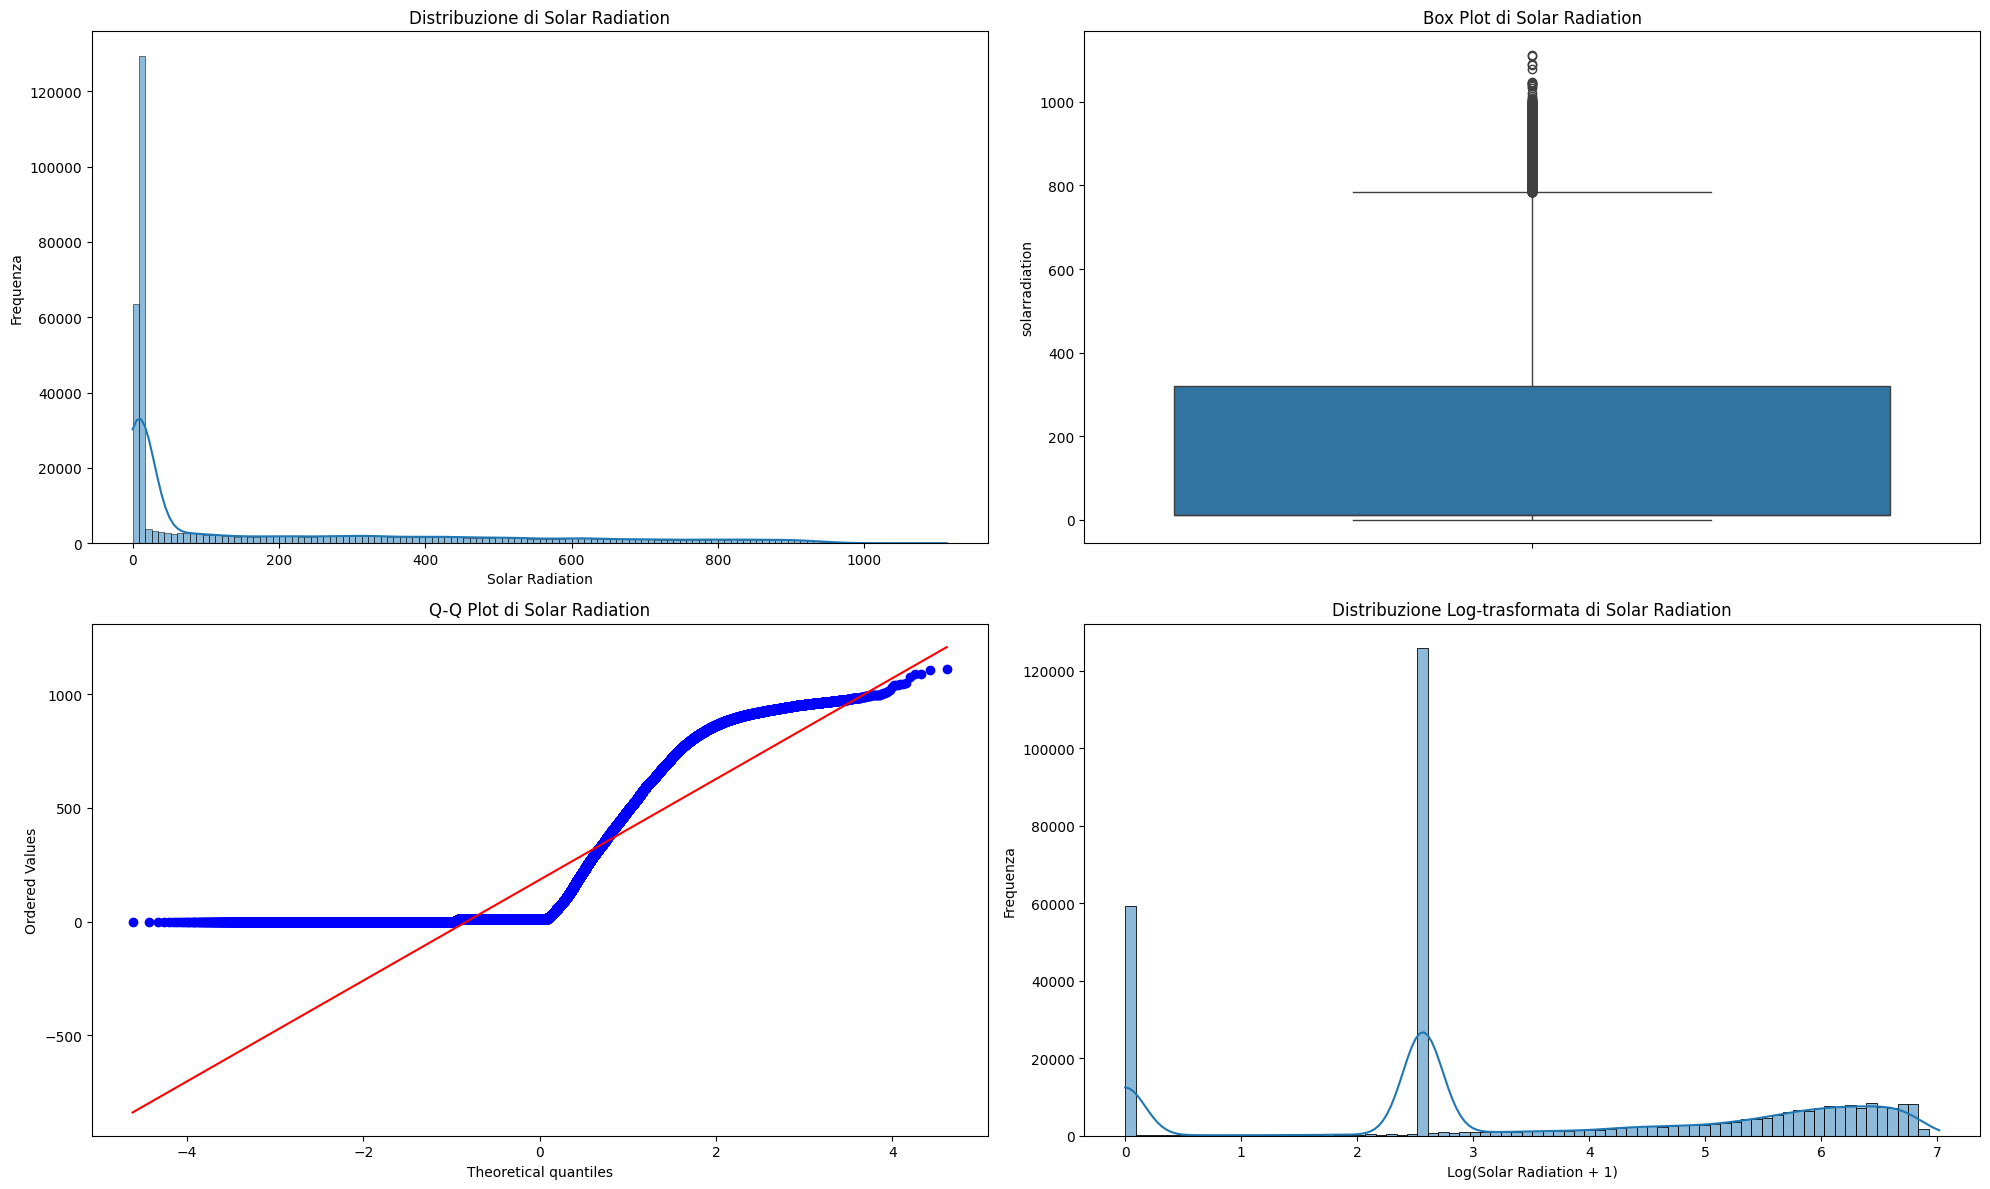

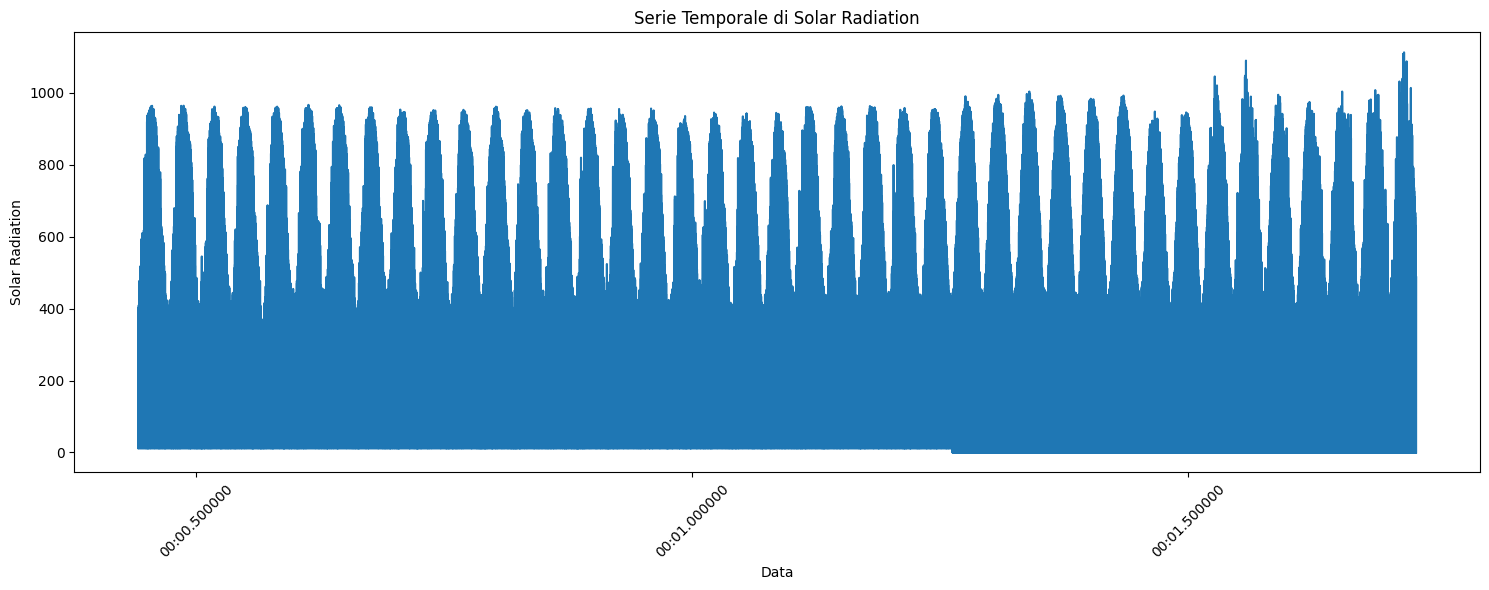

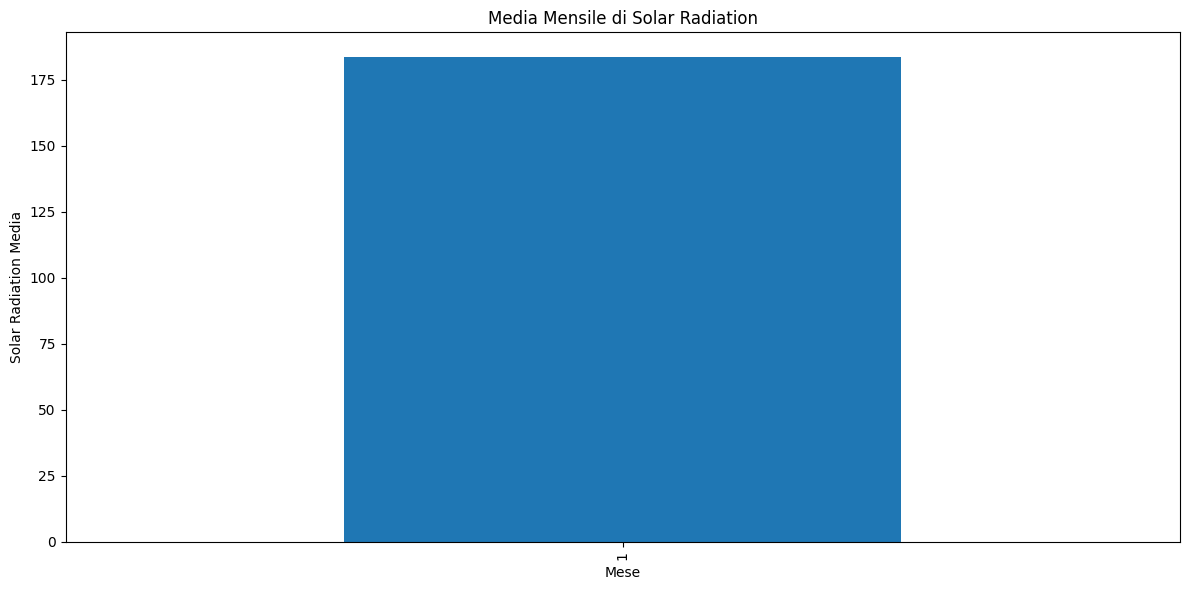


Statistiche principali di Solar Radiation:
--------------------------------------------------
count          : 357,679.0000
missing        : 64.0000
zeros          : 59,357.0000
mean           : 183.8441
median         : 12.0000
std            : 259.8156
min            : 0.0000
max            : 1,113.0000
skewness       : 1.3491
kurtosis       : 0.5914
percentile_1   : 0.0000
percentile_5   : 0.0000
percentile_10  : 0.0000
percentile_25  : 12.0000
percentile_50  : 12.0000
percentile_75  : 321.3083
percentile_90  : 624.6504
percentile_95  : 776.0000
percentile_99  : 907.6779

Suggerimenti per la normalizzazione:
--------------------------------------------------
- La distribuzione è fortemente asimmetrica (skewness > 1)
- Considerare una trasformazione logaritmica: np.log1p(x)
- Alta presenza di zeri (16.60%)
- Considerare un modello in due parti: classificazione degli zeri + regressione sui valori non-zero


{'count': 357679,
 'missing': 64,
 'zeros': 59357,
 'mean': 183.84409789852336,
 'median': 12.0,
 'std': 259.8156425752193,
 'min': 0.0,
 'max': 1113.0,
 'skewness': 1.3490904735404219,
 'kurtosis': 0.5914208419781612,
 'percentile_1': 0.0,
 'percentile_5': 0.0,
 'percentile_10': 0.0,
 'percentile_25': 12.0,
 'percentile_50': 12.0,
 'percentile_75': 321.3082580566406,
 'percentile_90': 624.6503662109386,
 'percentile_95': 776.0,
 'percentile_99': 907.677912597656}

In [17]:
analyze_distribution(df_updated, 'solarradiation', 'Solar Radiation')


Plot saved as: 2024-11-26_05-41_error_analysis.png


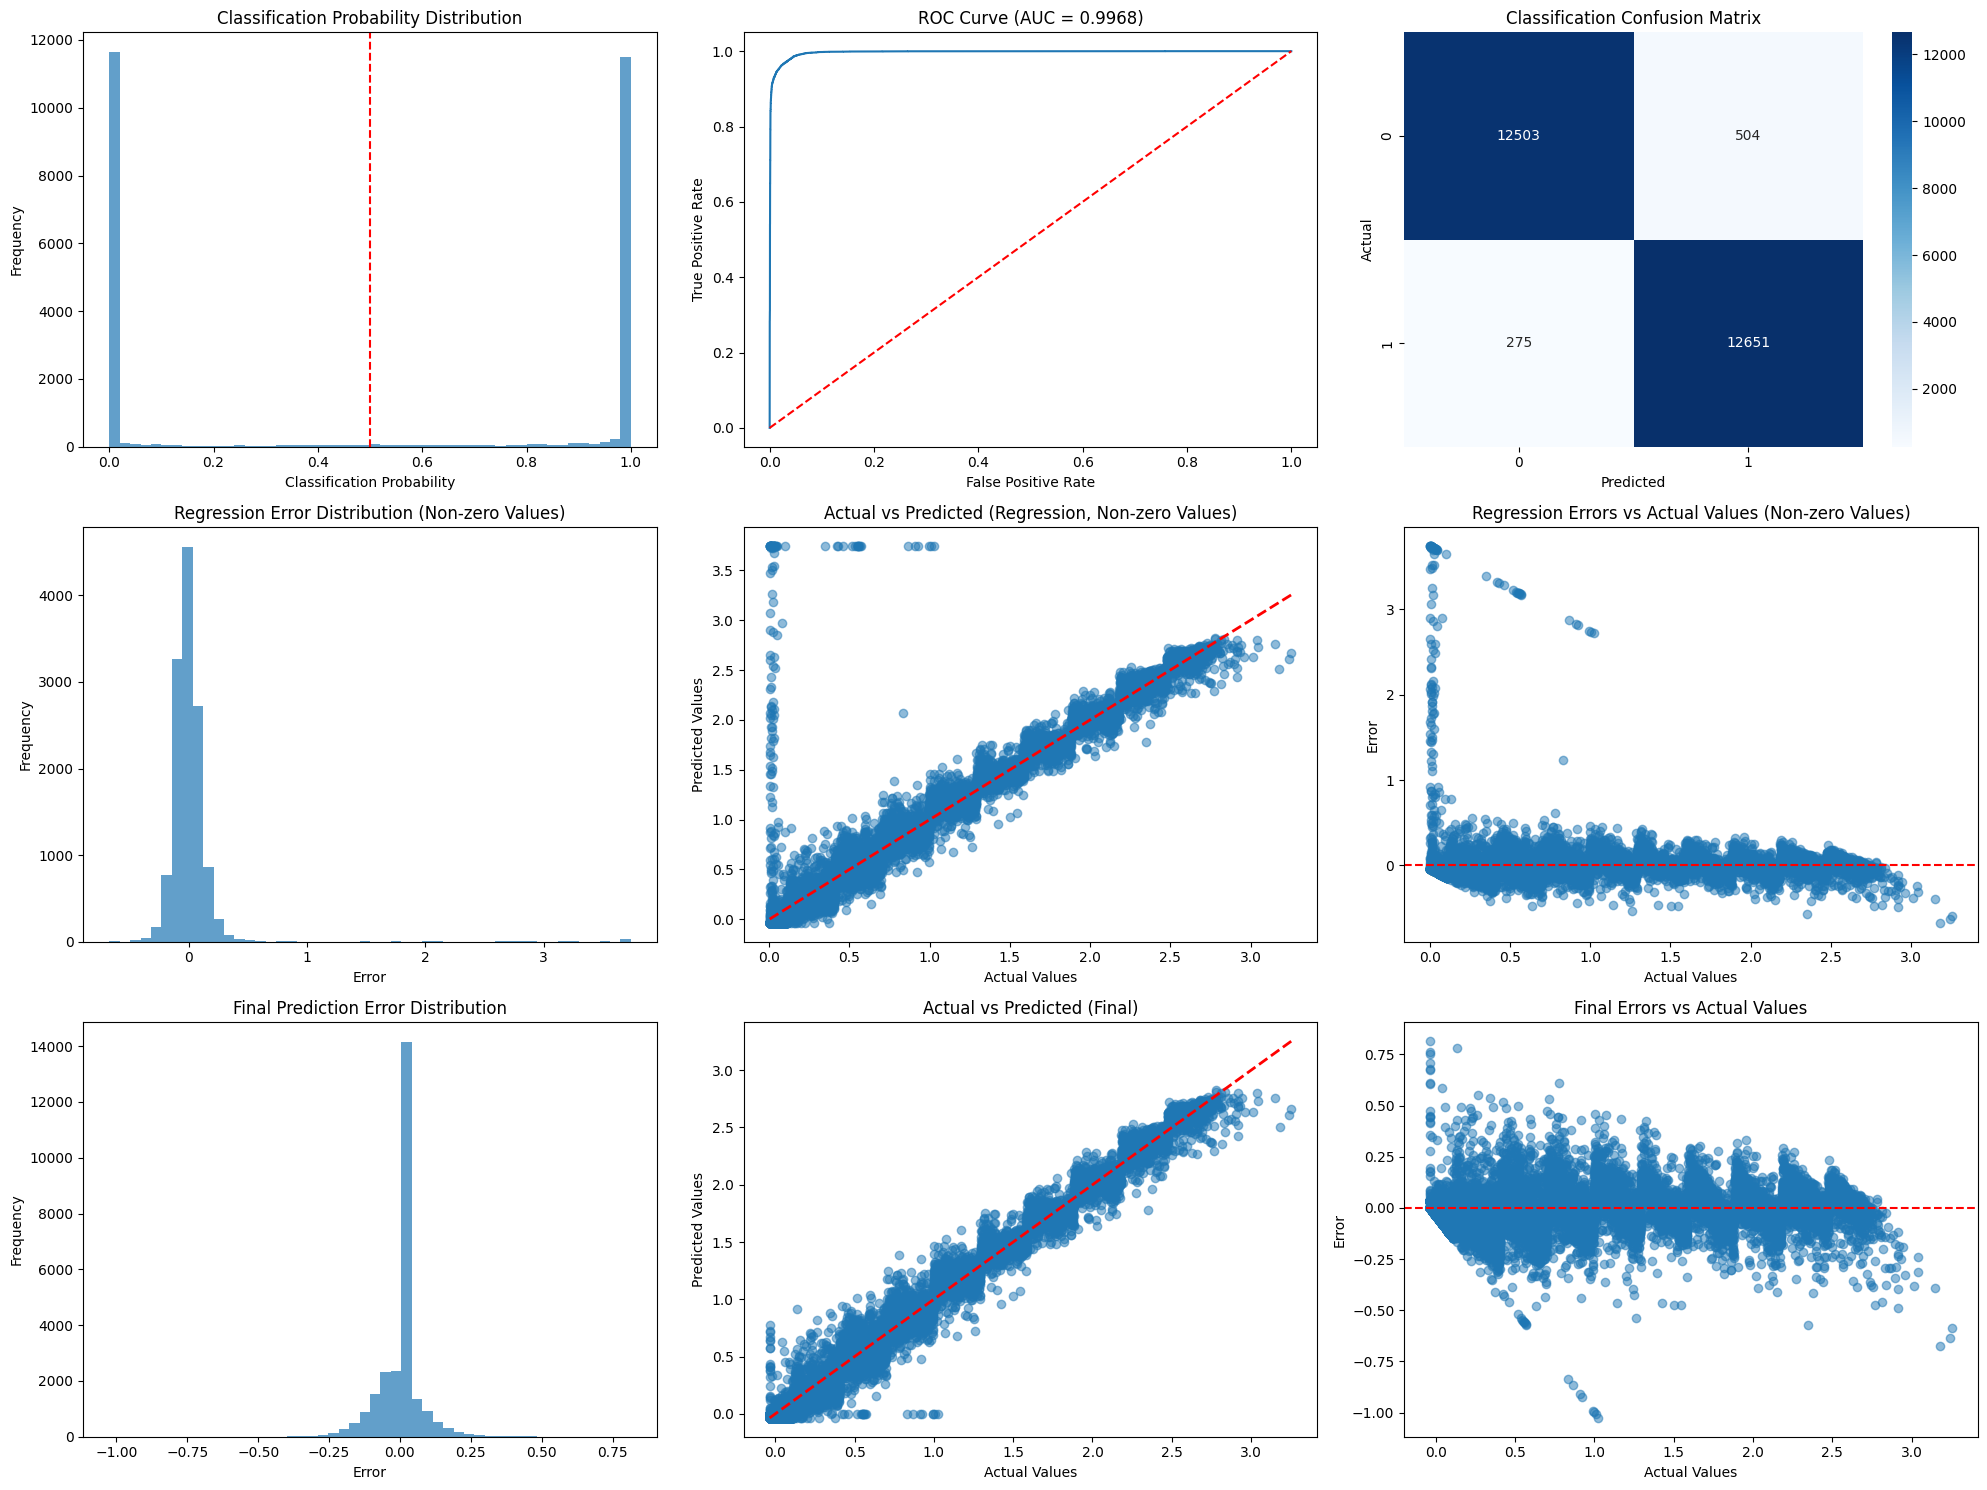


Classification Statistics:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     13007
         1.0       0.96      0.98      0.97     12926

    accuracy                           0.97     25933
   macro avg       0.97      0.97      0.97     25933
weighted avg       0.97      0.97      0.97     25933

AUC-ROC: 0.9968

Regression Statistics (Non-zero values):
MAE: 0.1056
RMSE: 0.2896
Mean error: 0.0143
Error std: 0.2892

Final Prediction Statistics:
MAE: 0.0583
RMSE: 0.0835
Mean error: 0.0113
Error std: 0.0827

Error Thresholds (Final Predictions):
Predictions within ±0.5: 99.9%
Predictions within ±1.0: 100.0%
Predictions within ±1.5: 100.0%
Predictions within ±2.0: 100.0%


In [20]:
def plot_error_analysis(y_true, predictions, folder_name=None):
    """
    Function to visualize prediction error analysis for the hybrid model

    Parameters:
    -----------
    y_true : array-like
        Actual values
    predictions : tuple
        Tuple containing (classification_pred, regression_pred, final_pred)
    folder_name : str, optional
        Directory to save plots. If None, plots are only displayed

    Generates:
    ----------
    - Classification analysis plots
    - Regression error analysis plots
    - Final prediction error analysis plots
    """
    from sklearn.metrics import roc_curve

    # Unpack predictions
    classification_pred, regression_pred, final_pred = predictions

    # Convert to 1D numpy arrays if needed
    y_true = np.ravel(y_true)
    classification_pred = np.ravel(classification_pred)
    regression_pred = np.ravel(regression_pred)
    final_pred = np.ravel(final_pred)

    # Create binary ground truth
    y_true_binary = (y_true > 0).astype(float)

    # Calculate errors for regression and final predictions
    regression_errors = regression_pred - y_true
    final_errors = final_pred - y_true

    # Create main figure
    plt.figure(figsize=(20, 15))

    # Classification Analysis (Top Row)
    # Plot 1: Classification Distribution
    plt.subplot(3, 3, 1)
    plt.hist(classification_pred, bins=50, alpha=0.7)
    plt.axvline(x=0.5, color='r', linestyle='--')
    plt.title('Classification Probability Distribution')
    plt.xlabel('Classification Probability')
    plt.ylabel('Frequency')

    # Plot 2: ROC Curve
    plt.subplot(3, 3, 2)
    fpr, tpr, _ = roc_curve(y_true_binary, classification_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve (AUC = {roc_auc_score(y_true_binary, classification_pred):.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Plot 3: Classification Confusion Matrix
    plt.subplot(3, 3, 3)
    cm = confusion_matrix(y_true_binary, classification_pred > 0.5)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Regression Analysis (Middle Row)
    # Plot 4: Regression Error Distribution
    plt.subplot(3, 3, 4)
    plt.hist(regression_errors[y_true > 0], bins=50, alpha=0.7)
    plt.title('Regression Error Distribution (Non-zero Values)')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 5: Actual vs Predicted (Regression)
    plt.subplot(3, 3, 5)
    mask_nonzero = y_true > 0
    plt.scatter(y_true[mask_nonzero], regression_pred[mask_nonzero], alpha=0.5)
    plt.plot([y_true[mask_nonzero].min(), y_true[mask_nonzero].max()],
             [y_true[mask_nonzero].min(), y_true[mask_nonzero].max()], 'r--', lw=2)
    plt.title('Actual vs Predicted (Regression, Non-zero Values)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 6: Regression Errors vs Actual Values
    plt.subplot(3, 3, 6)
    plt.scatter(y_true[mask_nonzero], regression_errors[mask_nonzero], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Regression Errors vs Actual Values (Non-zero Values)')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    # Final Predictions Analysis (Bottom Row)
    # Plot 7: Final Error Distribution
    plt.subplot(3, 3, 7)
    plt.hist(final_errors, bins=50, alpha=0.7)
    plt.title('Final Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 8: Actual vs Predicted (Final)
    plt.subplot(3, 3, 8)
    plt.scatter(y_true, final_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted (Final)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 9: Final Errors vs Actual Values
    plt.subplot(3, 3, 9)
    plt.scatter(y_true, final_errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Final Errors vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    plt.tight_layout()

    # Save plot if directory is specified
    if folder_name is not None:
        try:
            filename = f'{folder_name}_error_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
        except Exception as e:
            print(f"\nError saving plot: {str(e)}")

    plt.show()

    # Print comprehensive statistics
    print("\nClassification Statistics:")
    print(classification_report(y_true_binary, classification_pred > 0.5))
    print(f"AUC-ROC: {roc_auc_score(y_true_binary, classification_pred):.4f}")

    print("\nRegression Statistics (Non-zero values):")
    mask_nonzero = y_true > 0
    if np.any(mask_nonzero):
        print(f"MAE: {np.mean(np.abs(regression_errors[mask_nonzero])):.4f}")
        print(f"RMSE: {np.sqrt(np.mean(regression_errors[mask_nonzero] ** 2)):.4f}")
        print(f"Mean error: {np.mean(regression_errors[mask_nonzero]):.4f}")
        print(f"Error std: {np.std(regression_errors[mask_nonzero]):.4f}")

    print("\nFinal Prediction Statistics:")
    print(f"MAE: {np.mean(np.abs(final_errors)):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(final_errors ** 2)):.4f}")
    print(f"Mean error: {np.mean(final_errors):.4f}")
    print(f"Error std: {np.std(final_errors):.4f}")

    # Calculate percentage of errors within thresholds
    thresholds = [0.5, 1.0, 1.5, 2.0]
    print("\nError Thresholds (Final Predictions):")
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(final_errors) <= threshold) * 100
        print(f"Predictions within ±{threshold}: {within_threshold:.1f}%")

# Example usage
plot_error_analysis(y_test, predictions, folder_name=folder_name)